<b><font color="F37321" size="6px">
    Hanwha General Insurance
</font></b>

<b><font color="654321" size="5px">
    Mask R-CNN
</font></b>

---

# Definition

## Import

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

In [2]:
import cv2
import sys
from datetime import datetime
import pickle
import random
import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from glob import glob

In [2]:
# %matplotlib inline 

/raid/nvidia/jupyterhub/notebook/kidi/agilesoda/damage_class_detection


In [4]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model_Copy1 as modellib
from mrcnn import visualize
from mrcnn import simdotation as annotation
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = "ckpt/resnet50_832_from_scratch_9A" # .format(datetime.today().strftime('%y%m%d%H'))

from mrcnn import simdotation as annotation

Using TensorFlow backend.


## Configurations

In [1]:
from configs.config_9A import CarConfig

config = CarConfig()
config.display()

KeyError: 'CUDA_VISIBLE_DEVICES'

## Dataset

In [6]:
class TYDataset(utils.Dataset):
    def date_list(self, dataset, flip, rotation, bright):

        from glob import glob
        from tqdm import tqdm
        idx = 0
        
        # Add classes
        for name in list(sorted(annotation.MASK_CLS_DICT.keys())):
            cls = annotation.MASK_CLS_DICT[name]
            self.add_class("car", int(cls) + 1, str(name))
        
        for lr in flip:
            
            for rt in rotation:
                
                for br in bright:

                    for info in tqdm(dataset):

                        try:

                            IMAGEPATH, MASKPATH, SHAPE, COORDINATE = info

                            for coor in COORDINATE:

                                self.add_image(
                                    source="car",
                                    image_id=idx,
                                    path=IMAGEPATH,
                                    masks_path=[MASKPATH],
                                    flip=lr,
                                    crop=coor,
                                    angle=rt,
                                    brightness=br,
                                )
                                idx += 1

                        except:

                            pass
                        
    def load_image(self, image_id):

        path = self.image_info[image_id]["path"]
        flip = self.image_info[image_id]["flip"]
        crop = self.image_info[image_id]["crop"]
        angle = self.image_info[image_id]["angle"]
        brightness = self.image_info[image_id]["brightness"]

        return annotation.image_gbr_to_rgb(path, flip, crop, angle, brightness)

    def load_mask(self, image_id):

        path = self.image_info[image_id]["masks_path"]
        flip = self.image_info[image_id]["flip"]
        crop = self.image_info[image_id]["crop"]
        angle = self.image_info[image_id]["angle"]

        mask, cls = annotation.mask_path_list(path, flip, crop, angle)

        return mask, cls.astype(np.int32)

### create dataset

In [7]:
with open('../kidi_data/damage_class_mask/train/pickles/train_190613.p', 'rb') as p:
    traindataset = pickle.load(p)

with open('../kidi_data/damage_class_mask/eval/pickles/eval_190613.p', 'rb') as p:
    testdataset = pickle.load(p)

In [8]:
traindataset[2]

['../kidi_data/damage_class_mask/train/images/000001352.jpg',
 '../kidi_data/damage_class_mask/train/annotations/000001352.png',
 (600, 800, 3),
 [[0, 600, 0, 800]]]

In [9]:
dataset_val = TYDataset()
dataset_val.date_list(
    dataset=testdataset,
    flip=[True, False],
    rotation = [0],
    bright = [2/3, 3/4, 1, 4/3, 3/2],
)
dataset_val.prepare()

100%|██████████| 884/884 [00:00<00:00, 164694.39it/s]


In [10]:
# config.VALIDATION_STEPS = len(dataset_val.image_ids) // config.BATCH_SIZE
config.VALIDATION_STEPS = 5
print(config.VALIDATION_STEPS)

5


### <b><font color="123456"> Vis. Dataset </font></b></h3>

23064


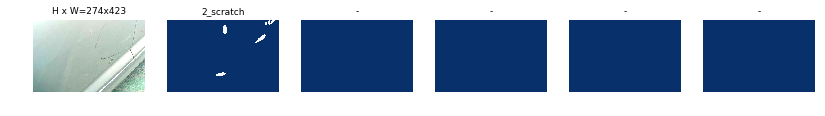

21278


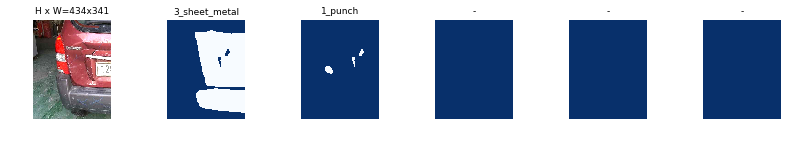

12420


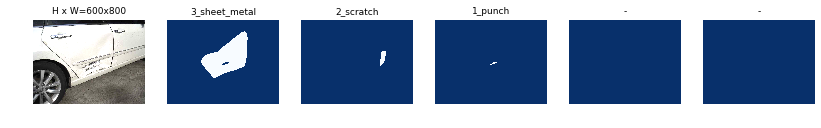

14605


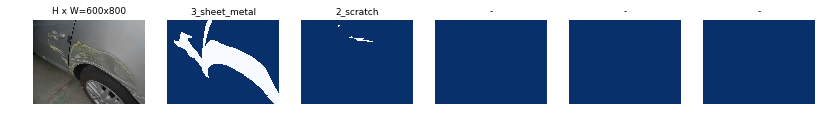

15775


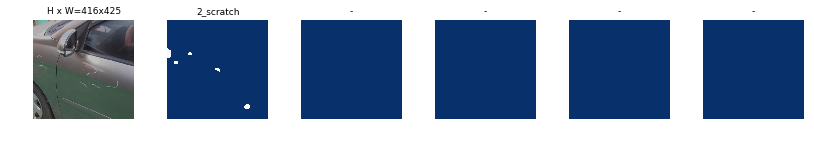

In [11]:
image_ids = np.random.choice(dataset_val.image_ids, 5, replace=False)

for image_id in image_ids:

    print(image_id)

    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids,
                                dataset_val.class_names, 5)

In [12]:
dataset_train = TYDataset()
dataset_train.date_list(
    dataset=traindataset,
    flip=[False, True],
    bright=[2/3, 1, 3/2],
    rotation=[0]
#     bright=[2/3, 3/2], 
#     rotation = [-16, -8, 8, 16],
)
dataset_train.prepare()

100%|██████████| 7808/7808 [00:00<00:00, 179154.73it/s]


In [13]:
# dataset_train = TYDataset()
# dataset_train.date_list(
#     dataset=traindataset,
#     flip=[False, True],
#     bright = [2/3, 3/4, 4/5, 1, 5/4, 4/3, 3/2],
#     rotation = [-16, -8, -4, 0, 4, 8, 16],
# )
# dataset_train.prepare()

In [14]:
IPE = 10

In [15]:
config.STEPS_PER_EPOCH = len(dataset_train.image_ids) // (CarConfig.IMAGES_PER_GPU * CarConfig.GPU_COUNT)
config.STEPS_PER_EPOCH = 10000
print(config.STEPS_PER_EPOCH)

10000


### <b><font color="123456"> Vis. Dataset </font></b></h3>

104277


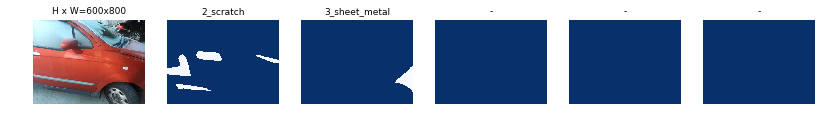

43645


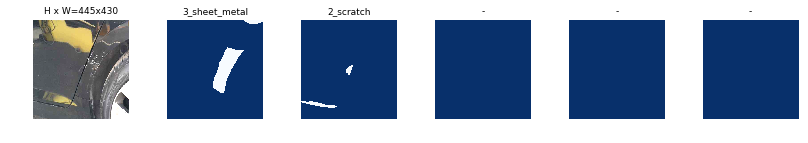

42075


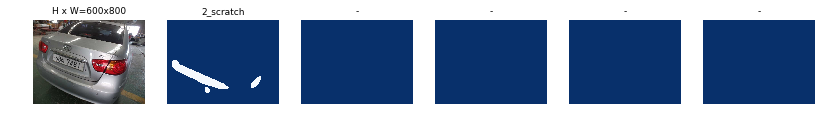

93165


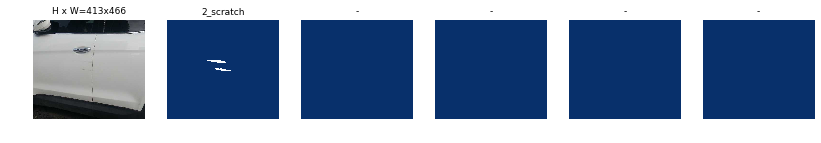

128330


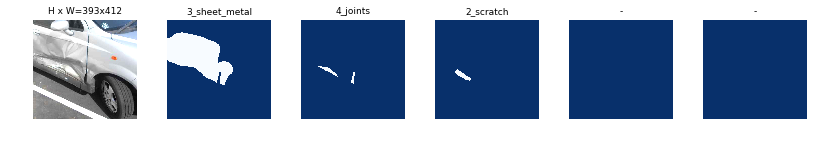

27901


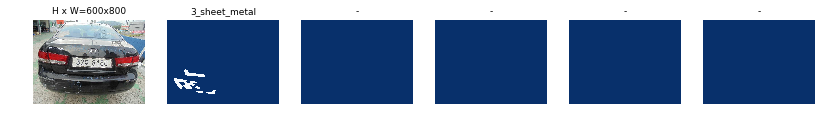

71452


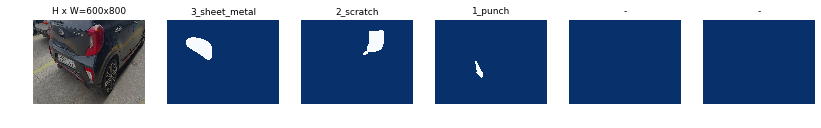

18996


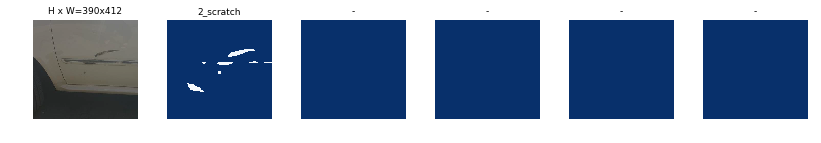

2177


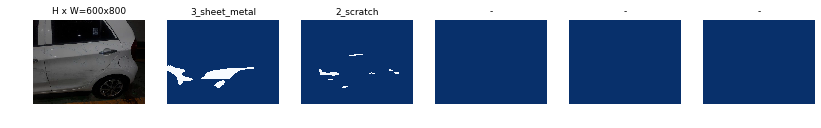

100882


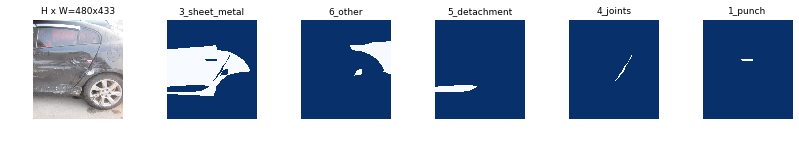

In [16]:
image_ids = np.random.choice(dataset_train.image_ids, 10, replace=False)

for image_id in image_ids:

    print(image_id)

    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids,
                                dataset_train.class_names, 5)

## Bounding Boxes

image_id  14646 
image                    shape: (600, 800, 3)         min:    0.00000  max:  170.00000  uint8
mask                     shape: (600, 800, 10)        min:    0.00000  max:  255.00000  uint8
class_ids                shape: (10,)                 min:    2.00000  max:    3.00000  int32
bbox                     shape: (10, 4)               min:    0.00000  max:  710.00000  int32


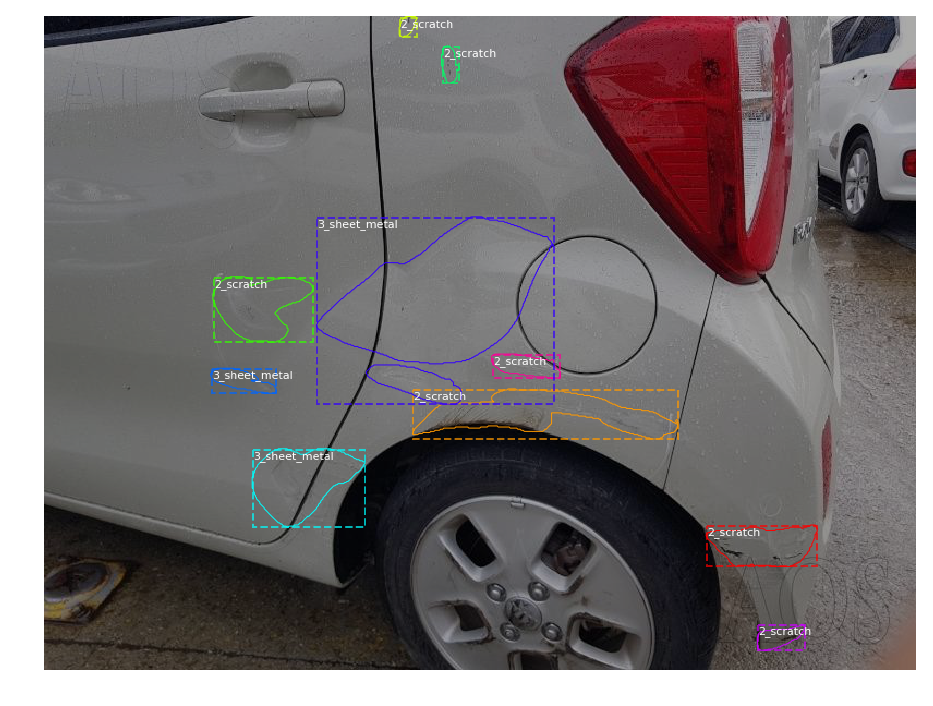

In [17]:
# Load random image and mask.
image_id = random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids,
                            dataset_train.class_names)

## Resize Images

image_id:  101752 
Original shape:  (464, 249, 3)
image                    shape: (832, 832, 3)         min:    0.00000  max:  249.00000  uint8
mask                     shape: (832, 832, 5)         min:    0.00000  max:  255.00000  uint8
class_ids                shape: (5,)                  min:    1.00000  max:    3.00000  int32
bbox                     shape: (5, 4)                min:  168.00000  max:  639.00000  int32


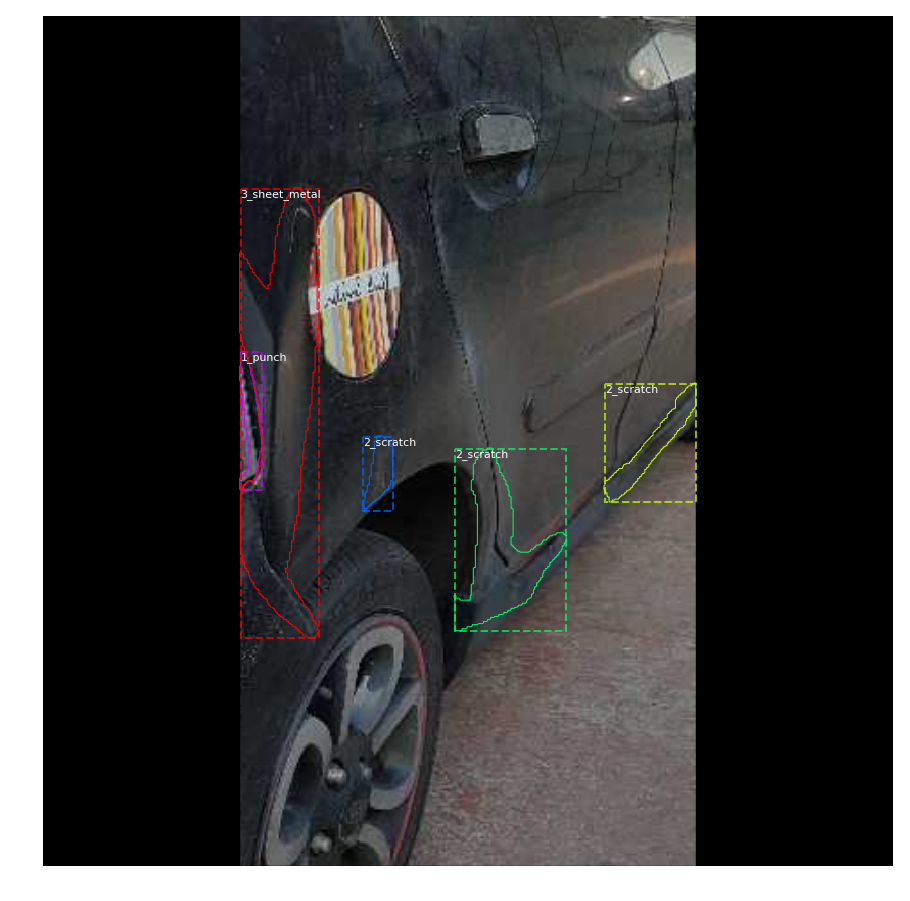

In [18]:
# Load random image and mask.
image_id = np.random.choice(dataset_train.image_ids, 1)[0]
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
original_shape = image.shape

# Resize
image, window, scale, padding, crop = utils.resize_image(
    image,
    min_dim=config.IMAGE_MIN_DIM,
    max_dim=config.IMAGE_MAX_DIM,
    min_scale=config.IMAGE_MIN_SCALE,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding, crop)

# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset_train.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids,
                            dataset_train.class_names)

## Anchors

In [19]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(
    config.RPN_ANCHOR_SCALES,
    config.RPN_ANCHOR_RATIOS,
    backbone_shapes,
    config.BACKBONE_STRIDES,
    config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
anchors_per_cell = 9
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  518661
Scales:  ([8, 16, 32], [16, 32, 64], [32, 64, 128], [64, 128, 256], [128, 256, 512])
ratios:  [0.8333333333333334, 1.4615384615384615, 2.727272727272727]
Anchors per Cell:  9
Levels:  5
Anchors in Level 0: 389376
Anchors in Level 1: 97344
Anchors in Level 2: 24336
Anchors in Level 3: 6084
Anchors in Level 4: 1521


Level 0. Anchors: 389376  Feature map Shape: [208 208]
Level 1. Anchors:  97344  Feature map Shape: [104 104]
Level 2. Anchors:  24336  Feature map Shape: [52 52]
Level 3. Anchors:   6084  Feature map Shape: [26 26]
Level 4. Anchors:   1521  Feature map Shape: [13 13]


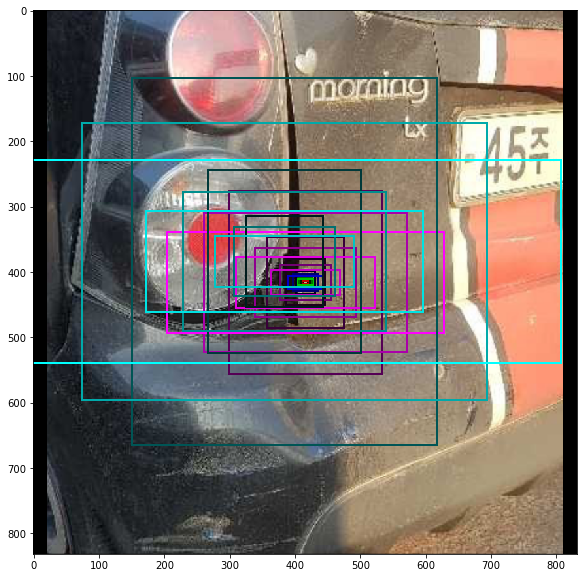

In [20]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset_train.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset_train, 
                                                    config,
                                                    image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    
    colors = visualize.random_colors(levels)
    colors = [(1.0, 0.0, 0.0),
              (0.0, 1.0, 0.0),
              (0.0, 0.0, 1.0),
              (1.0, 0.0, 1.0),
              (0.0, 1.0, 1.0),]
    
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level])  # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start + anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], backbone_shapes[level]))
    
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    
    # level_center = center_cell_index * anchors_per_cell
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) + center_cell[1] / config.RPN_ANCHOR_STRIDE
    )
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center + anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            linewidth=2,
            facecolor='none',
            edgecolor=(i + 1) * np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)

# Training

## Ceate Model

In [21]:
print(MODEL_DIR)

ckpt/resnet50_832_from_scratch_9A


In [22]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.


In [23]:
# utils.download_trained_weights("Mobile_Mask_RCNN/mobile_mask_rcnn_coco.h5")

In [24]:
# model_path = model.find_last()[1]
model_path = "ckpt/mask_rcnn_coco.h5"

In [25]:
model_path

'ckpt/mask_rcnn_coco.h5'

In [26]:
try:
    model.load_weights(model_path, by_name=True)
    
except:
    model.load_weights(model_path, by_name=True, exclude=[
        "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

ValueError: Layer #359 (named "rpn_model"), weight <tf.Variable 'rpn_class_raw/kernel:0' shape=(1, 1, 512, 18) dtype=float32_ref> has shape (1, 1, 512, 18), but the saved weight has shape (6, 512, 1, 1).

## Run!

In [ ]:
try:
    model.train(
        dataset_train,
        dataset_val,
        learning_rate=config.LEARNING_RATE,
        epochs=5,
        layers='all')

except KeyboardInterrupt:
    print()
    print("(Ctrl + c)")


Starting at epoch 0. LR=1e-05

Checkpoint Path: ckpt/resnet50_832_from_scratch_9A/damage_detector20190617T1521/mask_rcnn_damage_detector_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b   

/home/kidi/.conda/envs/kidi/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
10000/10000 [==============================] - 17750s 2s/step - loss: 3.0521 - rpn_class_loss: 0.2755 - rpn_bbox_loss: 1.1323 - mrcnn_class_loss: 0.3325 - mrcnn_bbox_loss: 0.7363 - mrcnn_mask_loss: 0.5755 - val_loss: 2.9369 - val_rpn_class_loss: 0.1761 - val_rpn_bbox_loss: 1.2041 - val_mrcnn_class_loss: 0.2740 - val_mrcnn_bbox_loss: 0.6752 - val_mrcnn_mask_loss: 0.6075
Epoch 2/5
10000/10000 [==============================] - 17143s 2s/step - loss: 2.5406 - rpn_class_loss: 0.1980 - rpn_bbox_loss: 0.8496 - mrcnn_class_loss: 0.3470 - mrcnn_bbox_loss: 0.6119 - mrcnn_mask_loss: 0.5341 - val_loss: 2.3193 - val_rpn_class_loss: 0.1646 - val_rpn_bbox_loss: 0.6250 - val_mrcnn_class_loss: 0.4527 - val_mrcnn_bbox_loss: 0.5813 - val_mrcnn_mask_loss: 0.4957
Epoch 3/5
10000/10000 [==============================] - 17160s 2s/step - loss: 2.3748 - rpn_class_loss: 0.1671 - rpn_bbox_loss: 0.7567 - mrcnn_class_loss: 0.3914 - mrcnn_bbox_loss: 0.5607 - mrcnn_mask_loss: 0.4989 - val_loss: 2.5106 - 

# 끝!